circuitId       int64
circuitRef     object
name           object
location       object
country        object
lat           float64
lng           float64
alt             int64
url            object
dtype: object
driverId        int64
driverRef      object
number         object
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object
resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object
raceId          int64
year            int64
round           int64
circuitId 

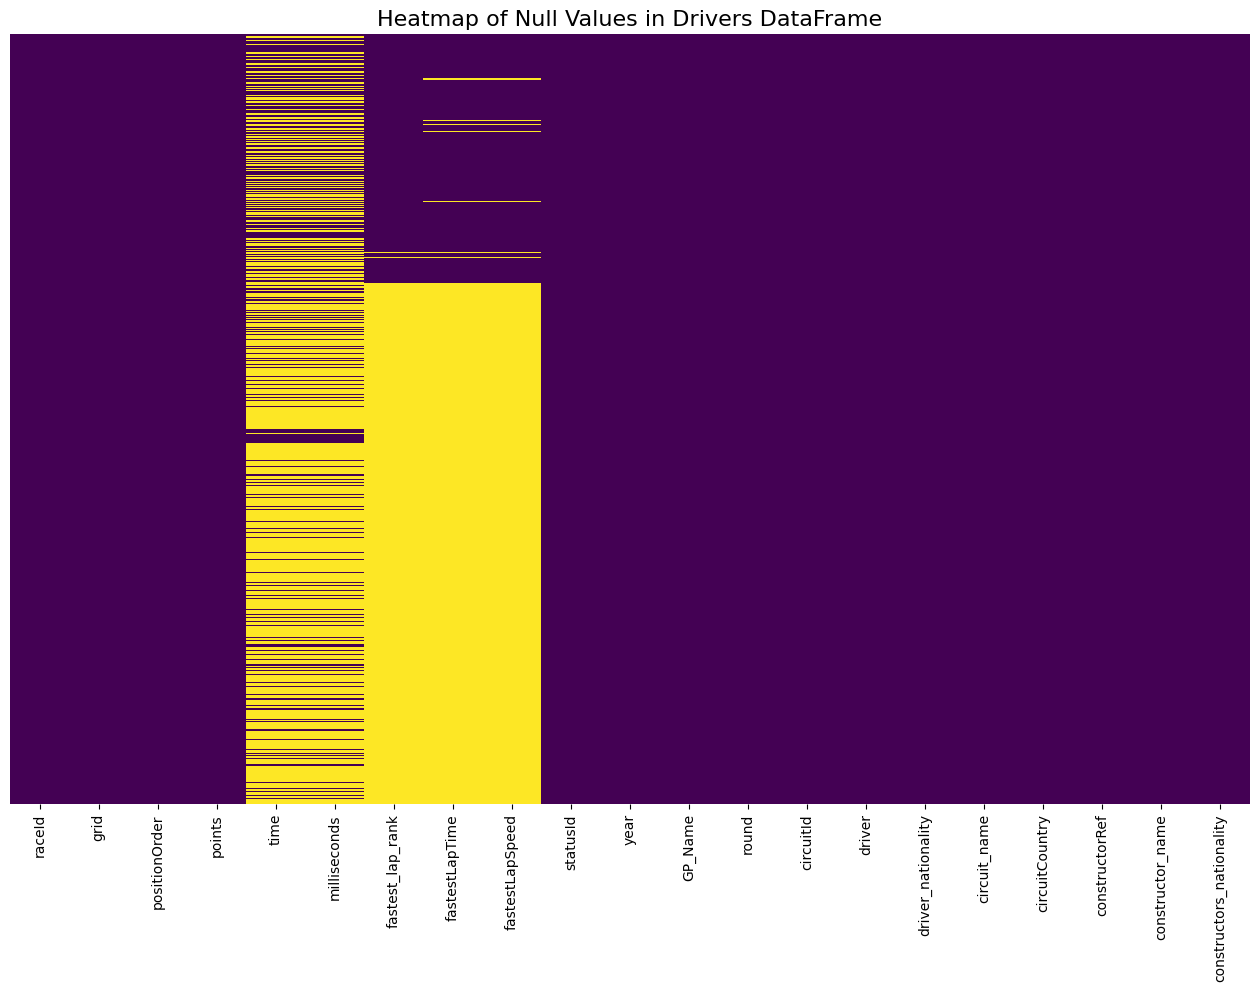

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


drivers = pd.read_csv('drivers.csv')
circuits = pd.read_csv('circuits.csv')
results = pd.read_csv('results.csv')
constructors = pd.read_csv('constructors.csv')
races=pd.read_csv('races.csv')
imp_df = [circuits, drivers,  results,races,constructors]


for df in imp_df:
    df.replace('\\N', np.nan, inplace=True)
    print(df.dtypes)    
    
races.drop(columns=['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time','time'],inplace=True)


df=pd.merge(results,races[['raceId','year','name','round','circuitId']],on='raceId',how='left')
df=pd.merge(df,drivers[['driverId','driverRef','nationality']],on='driverId',how='left')
df=pd.merge(df,circuits[['circuitId','name','country']],on='circuitId',how='left')
df=df.sort_values(by=['year','round','positionOrder'],ascending=[False,True,True])
df=pd.merge(df,constructors[['constructorId','constructorRef','name','nationality']],on='constructorId',how='left')
df.drop(columns=['number','position','positionText','laps','fastestLap','resultId','driverId','constructorId'],axis=1,inplace=True)
df.rename(columns={'rank':'fastest_lap_rank','name_x':'GP_Name','nationality_x':'driver_nationality','name_y':'circuit_name','country':'circuitCountry','name':'constructor_name','nationality_y':'constructors_nationality','driverRef':'driver'},inplace=True)

plt.figure(figsize=(16, 10))

# Create a heatmap to visualize null values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# Add title and display the heatmap
plt.title('Heatmap of Null Values in Drivers DataFrame', fontsize=16)
plt.show()


In [2]:
df=df.sort_values(by=['year','round','positionOrder'],ascending=[False,True,True])

print(df.head(7))

# Select relevant columns
team_df = df[['raceId', 'year', 'circuit_name', 'constructor_name', 'positionOrder', 'points']].drop_duplicates()

# Mark Wins and Podiums
team_df['win'] = team_df['positionOrder'] == 1
team_df['podium'] = team_df['positionOrder'] <= 3

# Preview
print(team_df.head())


   raceId  grid  positionOrder  points         time milliseconds  \
0    1121     1              1    26.0  1:31:44.742      5504742   
1    1121     5              2    18.0      +22.457      5527199   
2    1121     4              3    15.0      +25.110      5529852   
3    1121     2              4    12.0      +39.669      5544411   
4    1121     3              5    10.0      +46.788      5551530   
5    1121     7              6     8.0      +48.458      5553200   
6    1121     9              7     6.0      +50.324      5555066   

  fastest_lap_rank fastestLapTime fastestLapSpeed  statusId  ...  \
0                1       1:32.608         210.383         1  ...   
1                4       1:34.364         206.468         1  ...   
2                6       1:34.507         206.156         1  ...   
3                2       1:34.090         207.069         1  ...   
4               12       1:35.065         204.946         1  ...   
5                5       1:34.476         206.2

In [3]:
team_success_overall = team_df.groupby(['constructor_name']).agg(
    total_races=('raceId', 'nunique'),
    total_wins=('win', 'sum'),
    total_podiums=('podium', 'sum'),
    total_points=('points', 'sum')
).reset_index()

# Calculate Win Rate and Podium Rate
team_success_overall['win_rate'] = (team_success_overall['total_wins'] / team_success_overall['total_races']) * 100
team_success_overall['podium_rate'] = (team_success_overall['total_podiums'] / team_success_overall['total_races']) * 100
team_success_overall['avg_points'] = team_success_overall['total_points'] / team_success_overall['total_races']

# Preview Overall Success Rates
print("Team Success Rates (Without Circuit Factor):")
print(team_success_overall.sort_values('win_rate', ascending=False))


Team Success Rates (Without Circuit Factor):
    constructor_name  total_races  total_wins  total_podiums  total_points  \
31             Brawn           17           8             15        172.00   
96      Kurtis Kraft           12           5             16        118.00   
139         Mercedes          317         129            298       7728.64   
69           Epperly            5           2              5         44.00   
115     Lotus-Climax           56          22             31        281.00   
..               ...          ...         ...            ...           ...   
198           Toyota          140           0             13        278.50   
205           Virgin           38           0              0          0.00   
204          Veritas            6           0              0          0.00   
207        Wetteroth            1           0              0          0.00   
210         Zakspeed           74           0              0          2.00   

      win_rate  po

In [4]:
# Aggregate Success Metrics With Circuit Factor
team_success_by_circuit = team_df.groupby(['circuit_name', 'constructor_name']).agg(
    total_races=('raceId', 'nunique'),
    total_wins=('win', 'sum'),
    total_podiums=('podium', 'sum'),
    total_points=('points', 'sum')
).reset_index()

# Calculate Win Rate and Podium Rate Per Circuit
team_success_by_circuit['win_rate'] = (team_success_by_circuit['total_wins'] / team_success_by_circuit['total_races']) * 100
team_success_by_circuit['podium_rate'] = (team_success_by_circuit['total_podiums'] / team_success_by_circuit['total_races']) * 100
team_success_by_circuit['avg_points'] = team_success_by_circuit['total_points'] / team_success_by_circuit['total_races']

# Preview Circuit-Based Success Rates
print("Team Success Rates (With Circuit Factor):")
print(team_success_by_circuit.sort_values(['circuit_name', 'win_rate'], ascending=[True, False]))


Team Success Rates (With Circuit Factor):
     circuit_name constructor_name  total_races  total_wins  total_podiums  \
3            AVUS          Ferrari            1           1              3   
0            AVUS              BRM            1           0              0   
1            AVUS    Cooper-Climax            1           0              0   
2            AVUS  Cooper-Maserati            1           0              0   
4            AVUS       Team Lotus            1           0              0   
...           ...              ...          ...         ...            ...   
2780       Zolder          Surtees            5           0              0   
2782       Zolder            Tecno            1           0              0   
2783       Zolder         Theodore            3           0              0   
2784       Zolder          Toleman            3           0              0   
2787       Zolder             Wolf            4           0              0   

      total_points  w

In [5]:
top_50_teams = team_success_overall.sort_values(by='win_rate', ascending=False).head(50)

# Preview Top 50 Teams
print("Top 50 Teams by Win Rate:")
print(top_50_teams[['constructor_name', 'total_wins', 'win_rate', 'podium_rate', 'avg_points']])


Top 50 Teams by Win Rate:
    constructor_name  total_wins   win_rate  podium_rate  avg_points
31             Brawn           8  47.058824    88.235294   10.117647
96      Kurtis Kraft           5  41.666667   133.333333    9.833333
139         Mercedes         129  40.694006    94.006309   24.380568
69           Epperly           2  40.000000   100.000000    8.800000
115     Lotus-Climax          22  39.285714    55.357143    5.017857
132       Matra-Ford           9  39.130435    65.217391    5.652174
203          Vanwall          10  34.482759    48.275862    3.724138
206           Watson           3  33.333333    55.555556    4.000000
166         Red Bull         122  30.964467    71.573604   19.474619
116       Lotus-Ford          11  25.000000    56.818182    4.750000
30     Brabham-Repco           8  24.242424    75.757576    5.303030
73           Ferrari         249  22.636364    75.636364   10.059645
134          McLaren         185  19.913886    54.682454    7.559203
46     C

/tmp/ipykernel_158797/2339793286.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_50_teams, x='win_rate', y='constructor_name', palette='viridis')


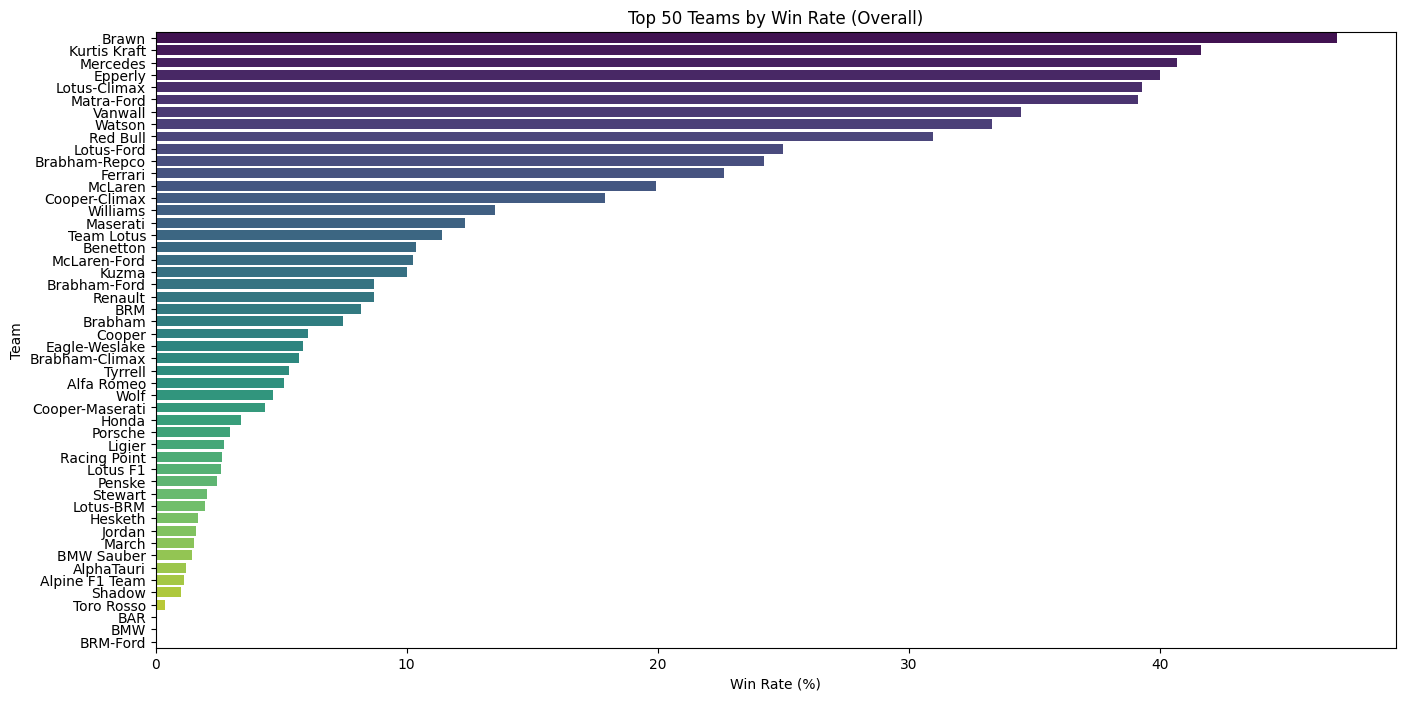

In [6]:
plt.figure(figsize=(16, 8))
sns.barplot(data=top_50_teams, x='win_rate', y='constructor_name', palette='viridis')
plt.title('Top 50 Teams by Win Rate (Overall)')
plt.xlabel('Win Rate (%)')
plt.ylabel('Team')
plt.show()


/tmp/ipykernel_158797/1007183333.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_50_teams, x='avg_points', y='constructor_name', palette='coolwarm')


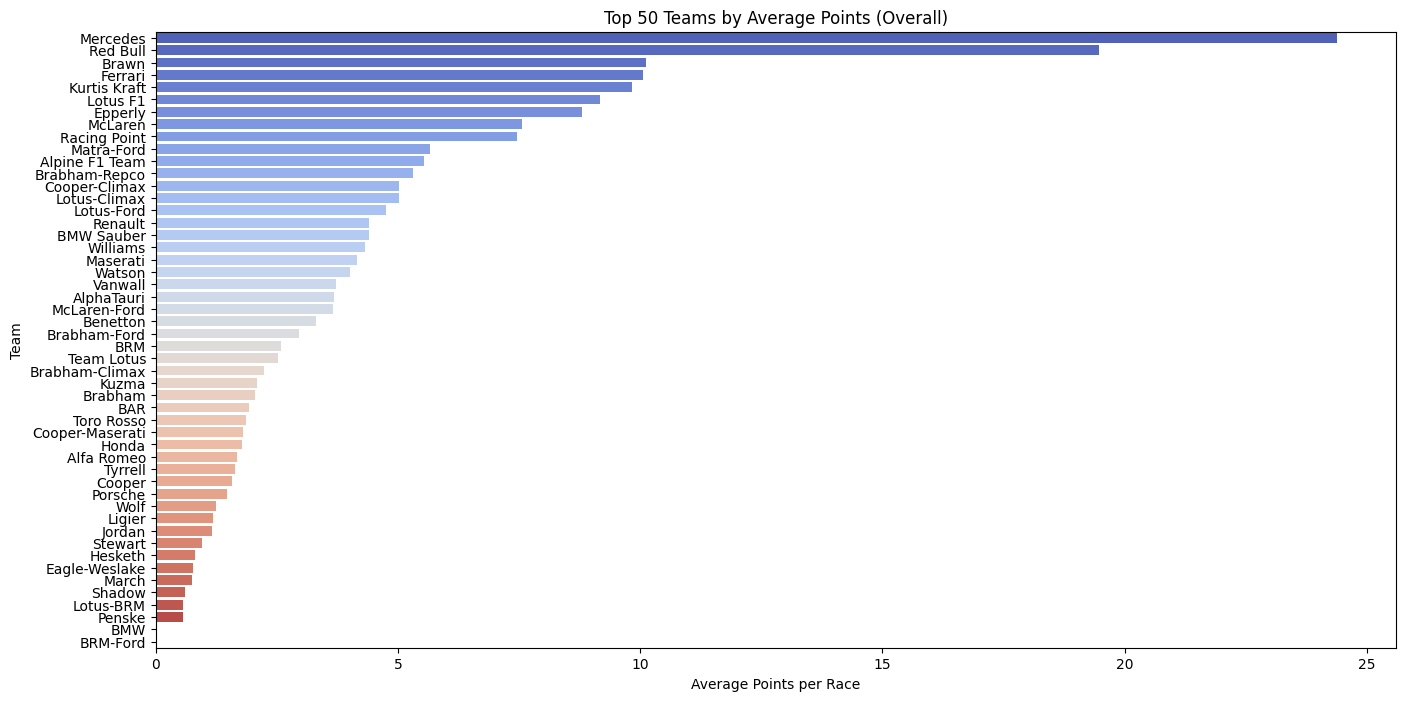

In [7]:
top_50_teams.sort_values(by='avg_points',ascending=False,inplace=True)
plt.figure(figsize=(16, 8))
sns.barplot(data=top_50_teams, x='avg_points', y='constructor_name', palette='coolwarm')
plt.title('Top 50 Teams by Average Points (Overall)')
plt.xlabel('Average Points per Race')
plt.ylabel('Team')
plt.show()


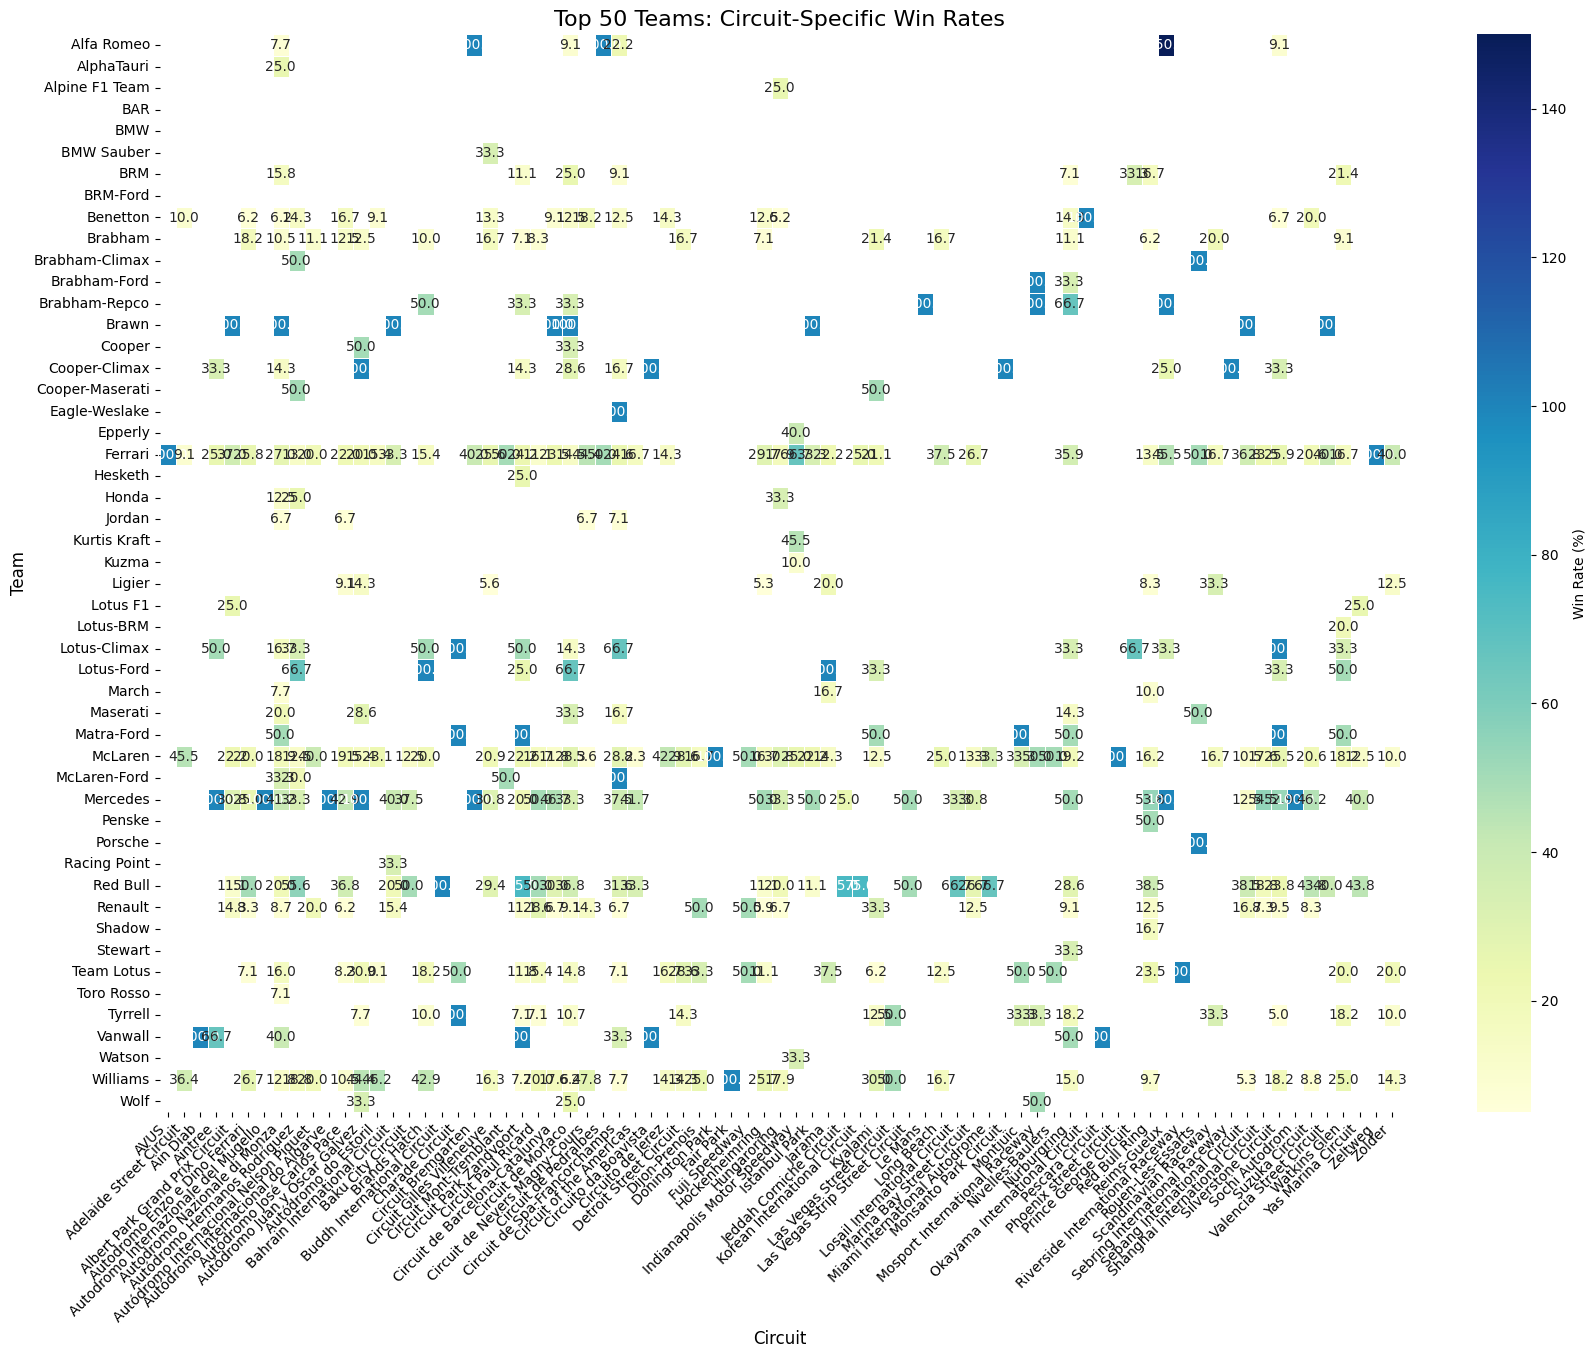

In [8]:


# Filter Circuit-Based Data for Top 50 Teams
team_success_by_circuit_filtered = team_success_by_circuit[team_success_by_circuit['constructor_name'].isin(top_50_teams['constructor_name'])]

# Pivot for Heatmap (Teams on Y-axis, Circuits on X-axis)
circuit_pivot = team_success_by_circuit_filtered.pivot(index='constructor_name', columns='circuit_name', values='win_rate')

# Mask Low Win Rates (<5%) for Clarity
mask = circuit_pivot < 5

# Plot Enhanced Heatmap
plt.figure(figsize=(20, 14))
sns.heatmap(circuit_pivot, annot=True, fmt=".1f", cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Win Rate (%)'}, mask=mask)
plt.title('Top 50 Teams: Circuit-Specific Win Rates', fontsize=16)
plt.xlabel('Circuit', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
